# Proportion Analysis for Barabasi-Albert and Complete networks
**Author**: Federica Imbriale  
**Description**: This notebook analyzes proportions of convergence for Experiment 1.

**Python Version**: 3.11 

**Torch version**: 2.2.2

**DGL version**: 1.1.0

In [3]:
import torch
import os 
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import h5py
import dgl 
import scipy.stats as stats
from tqdm import tqdm
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import warnings 

In [4]:
path = "/Users/fi3502phd/Desktop/SMS Data/Sim_dataframes/BasicProcessor" 
sims = pd.read_csv(f"{path}/bigsimpleframe.csv", index_col = 0) 

/var/folders/qf/q6vl1wz11b59rfbgvvvygs0c0000gq/T/ipykernel_21976/2522618628.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  sims = pd.read_csv(f"{path}/bigsimpleframe.csv", index_col = 0)


In [5]:
sims = sims.fillna(0)

In [6]:
pr = sims.groupby(["network_kind","network_size", "trials", "epsilon", "op", "reliability", "network_barabasialbert_attachments", "network_wattsstrogatz_knn", "network_wattsstrogatz_probability", "network_random_probability", "simulation_steps","action"]).count()

pr = (
    pr.unstack()
    .fillna(0)
    .droplevel(0, axis=1)
    .reset_index()
    .rename_axis(None, axis=1)
    .T.drop_duplicates()
    .T
)

# Calculate not B's
pr["not_B"] = pr["A"] + pr["?"]

# Convert the types columns to integers because they were output as floats
pr["A"] = pr["A"].astype(int)
pr["B"] = pr["B"].astype(int)
pr["not_B"] = pr["not_B"].astype(int)

In [7]:
# Create total column
pr["total"] = pr["not_B"] + pr["B"]
pr["total converged"] = pr["A"] + pr["B"]

pr["% of B out of total"] = (pr["B"] / pr["total"]) * 100
pr["% of B out of converged"] = (pr["B"] / pr["total converged"]) * 100 #this just gives B proportion, add not B or A 

## TABLES

**Accuracy of convergence for BALAGOYAL**

In [10]:
bg = pr.query("network_kind == 'barabasialbert' and op == 'BalaGoyalOp' and epsilon == 0.001")
bg_accuracy = bg[
    [ 
        "network_kind", 
        "network_size", 
        "trials", 
        "epsilon", 
        "op", 
        "network_barabasialbert_attachments",  
        "simulation_steps",
        "total",
        "total converged",
        "B",
        "not_B",
        "?",
        "A",
        "% of B out of total",
        "% of B out of converged"     
    ]
]

In [11]:
bg32_accuracy = bg_accuracy.query("network_size == 32")

In [12]:
bg32_accuracy

,network_kind,network_size,trials,epsilon,op,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
0,barabasialbert,32.0,64.0,0.001,BalaGoyalOp,1.0,100000.0,300,300,300,0,0.0,0,100.0,100.0
1,barabasialbert,32.0,64.0,0.001,BalaGoyalOp,2.0,100000.0,100,100,100,0,0.0,0,100.0,100.0
2,barabasialbert,32.0,64.0,0.001,BalaGoyalOp,4.0,100000.0,100,100,100,0,0.0,0,100.0,100.0
3,barabasialbert,32.0,64.0,0.001,BalaGoyalOp,8.0,100000.0,200,200,200,0,0.0,0,100.0,100.0
4,barabasialbert,32.0,64.0,0.001,BalaGoyalOp,16.0,100000.0,100,100,100,0,0.0,0,100.0,100.0


In [13]:
bg64_accuracy = bg_accuracy.query("network_size == 64")

In [14]:
bg64_accuracy

,network_kind,network_size,trials,epsilon,op,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
79,barabasialbert,64.0,64.0,0.001,BalaGoyalOp,1.0,100000.0,90,90,90,0,0.0,0,100.0,100.0
80,barabasialbert,64.0,64.0,0.001,BalaGoyalOp,2.0,100000.0,93,93,93,0,0.0,0,100.0,100.0
81,barabasialbert,64.0,64.0,0.001,BalaGoyalOp,4.0,100000.0,90,90,90,0,0.0,0,100.0,100.0
82,barabasialbert,64.0,64.0,0.001,BalaGoyalOp,8.0,100000.0,90,90,90,0,0.0,0,100.0,100.0
83,barabasialbert,64.0,64.0,0.001,BalaGoyalOp,16.0,100000.0,90,90,90,0,0.0,0,100.0,100.0
84,barabasialbert,64.0,64.0,0.001,BalaGoyalOp,32.0,100000.0,90,90,90,0,0.0,0,100.0,100.0


**Accuracy of convergence for GULLIBLE-BINOMIAL**

In [16]:
gulbin = pr.query("network_kind == 'barabasialbert' and op == 'UnreliableNetworkBasicGullibleBinomialOp' and epsilon == 0.001 and trials == 64")
gb_accuracy = gulbin[
    [ 
        "network_kind", 
        "network_size", 
        "trials", 
        "epsilon", 
        "op", 
        "reliability",
        "network_barabasialbert_attachments",  
        "simulation_steps",
        "total",
        "total converged",
        "B",
        "not_B",
        "?",
        "A",
        "% of B out of total",
        "% of B out of converged"     
    ]
]

In [17]:
gb32_accuracy = gb_accuracy.query("network_size == 32")
gb64_accuracy = gb_accuracy.query("network_size == 64")

A) SIZE 32

In [19]:
gb32_r75_accuracy = gb32_accuracy.query("reliability == 0.75")
gb32_r75_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
30,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,1.0,100000.0,75,32,32,43,43.0,0,42.666667,100.000000
31,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,2.0,100000.0,50,43,43,7,7.0,0,86.000000,100.000000
32,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,4.0,100000.0,50,49,48,2,1.0,1,96.000000,97.959184
33,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,8.0,100000.0,50,49,49,1,1.0,0,98.000000,100.000000
34,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,16.0,100000.0,50,49,49,1,1.0,0,98.000000,100.000000


In [20]:
gb32_r50_accuracy = gb32_accuracy.query("reliability == 0.50")
gb32_r50_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
25,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,1.0,100000.0,50,0,0,50,50.0,0,0.0,NaN
26,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,2.0,100000.0,50,16,16,34,34.0,0,32.0,100.000000
27,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,4.0,100000.0,150,120,120,30,30.0,0,80.0,100.000000
28,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,8.0,100000.0,50,47,44,6,3.0,3,88.0,93.617021
29,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,16.0,100000.0,50,46,46,4,4.0,0,92.0,100.000000


In [21]:
gb32_r25_accuracy = gb32_accuracy.query("reliability == 0.25")
gb32_r25_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
20,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,1.0,100000.0,50,0,0,50,50.0,0,0.0,NaN
21,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,2.0,100000.0,25,0,0,25,25.0,0,0.0,NaN
22,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,4.0,100000.0,25,9,9,16,16.0,0,36.0,100.000000
23,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,8.0,100000.0,100,70,62,38,30.0,8,62.0,88.571429
24,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,16.0,100000.0,100,90,74,26,10.0,16,74.0,82.222222


B) SIZE 64

In [23]:
gb64_r75_accuracy = gb64_accuracy.query("reliability == 0.75")
gb64_r75_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
97,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,1.0,100000.0,90,5,5,85,85.0,0,5.555556,100.0
98,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,2.0,100000.0,100,58,58,42,42.0,0,58.000000,100.0
99,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,4.0,100000.0,90,87,87,3,3.0,0,96.666667,100.0
100,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,8.0,100000.0,90,90,90,0,0.0,0,100.000000,100.0
101,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,16.0,100000.0,90,90,90,0,0.0,0,100.000000,100.0
102,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.75,32.0,100000.0,90,90,90,0,0.0,0,100.000000,100.0


In [24]:
gb64_r50_accuracy = gb64_accuracy.query("reliability == 0.50")
gb64_r50_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
91,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,1.0,100000.0,40,0,0,40,40.0,0,0.000000,NaN
92,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,2.0,100000.0,90,14,14,76,76.0,0,15.555556,100.000000
93,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,4.0,100000.0,73,44,44,29,29.0,0,60.273973,100.000000
94,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,8.0,100000.0,90,90,90,0,0.0,0,100.000000,100.000000
95,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,16.0,100000.0,90,90,90,0,0.0,0,100.000000,100.000000
96,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.5,32.0,100000.0,90,90,89,1,0.0,1,98.888889,98.888889


In [25]:
gb64_r25_accuracy = gb64_accuracy.query("reliability == 0.25")
gb64_r25_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
85,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,1.0,100000.0,100,0,0,100,100.0,0,0.000000,NaN
86,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,2.0,100000.0,100,0,0,100,100.0,0,0.000000,NaN
87,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,4.0,100000.0,2,0,0,2,2.0,0,0.000000,NaN
88,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,8.0,100000.0,110,67,67,43,43.0,0,60.909091,100.000000
89,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,16.0,100000.0,90,83,82,8,7.0,1,91.111111,98.795181
90,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,32.0,100000.0,110,106,101,9,4.0,5,91.818182,95.283019


**Accuracy of convergence for GULLIBLE-NEGATIVE EPSILON**

In [27]:
gulneg = pr.query("network_kind == 'barabasialbert' and op == 'UnreliableNetworkBasicGullibleNegativeEpsOp' and epsilon == 0.001 and trials == 64")
gneg_accuracy = gulneg[
    [ 
        "network_kind", 
        "network_size", 
        "trials", 
        "epsilon", 
        "op", 
        "reliability",
        "network_barabasialbert_attachments",  
        "simulation_steps",
        "total",
        "total converged",
        "B",
        "not_B",
        "?",
        "A",
        "% of B out of total",
        "% of B out of converged"     
    ]
]

In [28]:
gneg32_accuracy = gneg_accuracy.query("network_size == 32")
gneg64_accuracy = gneg_accuracy.query("network_size == 64")

A) SIZE 32

In [30]:
gneg32_r75_accuracy = gneg32_accuracy.query("reliability == 0.75")
gneg32_r75_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
45,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,1.0,100000.0,150,6,6,144,144.0,0,4.0,100.000000
46,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,2.0,100000.0,75,9,9,66,66.0,0,12.0,100.000000
47,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,4.0,100000.0,100,39,38,62,61.0,1,38.0,97.435897
48,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,8.0,100000.0,50,33,33,17,17.0,0,66.0,100.000000
49,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,16.0,100000.0,50,42,40,10,8.0,2,80.0,95.238095


In [31]:
gneg32_r50_accuracy = gneg32_accuracy.query("reliability == 0.50")
gneg32_r50_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
40,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,1.0,100000.0,75,3,0,75,72.0,3,0.00,0.000000
41,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,2.0,100000.0,45,2,0,45,43.0,2,0.00,0.000000
42,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,4.0,100000.0,160,12,2,158,148.0,10,1.25,16.666667
43,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,8.0,100000.0,60,16,3,57,44.0,13,5.00,18.750000
44,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,16.0,100000.0,100,45,20,80,55.0,25,20.00,44.444444


In [32]:
gneg32_r25_accuracy = gneg32_accuracy.query("reliability == 0.25")
gneg32_r25_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
35,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,1.0,100000.0,50,11,0,50,39.0,11,0.0,0.0
36,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,2.0,100000.0,75,38,0,75,37.0,38,0.0,0.0
37,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,4.0,100000.0,50,33,0,50,17.0,33,0.0,0.0
38,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,8.0,100000.0,50,37,0,50,13.0,37,0.0,0.0
39,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,16.0,100000.0,50,30,0,50,20.0,30,0.0,0.0


B) SIZE 64

In [34]:
gneg64_r75_accuracy = gneg64_accuracy.query("reliability == 0.75")
gneg64_r75_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
115,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,1.0,100000.0,50,0,0,50,50.0,0,0.0,NaN
116,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,2.0,100000.0,150,6,6,144,144.0,0,4.0,100.0
117,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,4.0,100000.0,100,8,8,92,92.0,0,8.0,100.0
118,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,8.0,100000.0,125,60,60,65,65.0,0,48.0,100.0
119,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,16.0,100000.0,100,80,80,20,20.0,0,80.0,100.0
120,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,32.0,100000.0,100,96,96,4,4.0,0,96.0,100.0


In [35]:
gneg64_r50_accuracy = gneg64_accuracy.query("reliability == 0.50")
gneg64_r50_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
109,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,1.0,100000.0,90,0,0,90,90.0,0,0.000000,NaN
110,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,2.0,100000.0,76,0,0,76,76.0,0,0.000000,NaN
111,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,4.0,100000.0,100,2,0,100,98.0,2,0.000000,0.000000
112,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,8.0,100000.0,46,2,0,46,44.0,2,0.000000,0.000000
113,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,16.0,100000.0,82,11,2,80,71.0,9,2.439024,18.181818
114,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.5,32.0,100000.0,59,16,8,51,43.0,8,13.559322,50.000000


In [36]:
gneg64_r25_accuracy = gneg64_accuracy.query("reliability == 0.25")
gneg64_r25_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
103,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,1.0,100000.0,50,5,0,50,45.0,5,0.0,0.0
104,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,2.0,100000.0,52,7,0,52,45.0,7,0.0,0.0
105,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,4.0,100000.0,90,27,0,90,63.0,27,0.0,0.0
106,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,8.0,100000.0,78,42,0,78,36.0,42,0.0,0.0
107,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,16.0,100000.0,90,56,0,90,34.0,56,0.0,0.0
108,barabasialbert,64.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.25,32.0,100000.0,90,61,0,90,29.0,61,0.0,0.0


**Accuracy of convergence for ALIGNED-BINOMIAL**


A) Size 64

In [39]:
albin64 = pr.query("network_size == 64 and network_kind == 'barabasialbert' and op == 'UnreliableNetworkModifiedAlignedBinomialOp' and epsilon == 0.001 and trials == 64")
albin64_accuracy= albin64[
    [ 
        "network_kind", 
        "network_size", 
        "trials", 
        "epsilon", 
        "op", 
        "reliability",
        "network_barabasialbert_attachments",  
        "simulation_steps",
        "total",
        "total converged",
        "B",
        "not_B",
        "?",
        "A",
        "% of B out of total",
        "% of B out of converged"     
    ]
]

In [40]:
albin64_r75_accuracy = albin64_accuracy.query("reliability == 0.75")
albin64_r75_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
139,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,1.0,100000.0,90,5,5,85,85.0,0,5.555556,100.0
140,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,2.0,100000.0,90,65,65,25,25.0,0,72.222222,100.0
141,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,4.0,100000.0,90,90,90,0,0.0,0,100.000000,100.0
142,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,8.0,100000.0,105,105,105,0,0.0,0,100.000000,100.0
143,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,16.0,100000.0,100,100,100,0,0.0,0,100.000000,100.0
144,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,32.0,100000.0,100,100,100,0,0.0,0,100.000000,100.0


In [41]:
albin64_r50_accuracy = albin64_accuracy.query("reliability == 0.50")
albin64_r50_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
133,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.5,1.0,100000.0,105,0,0,105,105.0,0,0.000000,NaN
134,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.5,2.0,100000.0,34,0,0,34,34.0,0,0.000000,NaN
135,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.5,4.0,100000.0,66,4,4,62,62.0,0,6.060606,100.000000
136,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.5,8.0,100000.0,53,8,8,45,45.0,0,15.094340,100.000000
137,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.5,16.0,100000.0,90,63,63,27,27.0,0,70.000000,100.000000
138,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.5,32.0,100000.0,90,88,81,9,2.0,7,90.000000,92.045455


In [42]:
albin64_r25_accuracy = albin64_accuracy.query("reliability == 0.25")
albin64_r25_accuracy.fillna(0)
albin64_r25_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
127,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.25,1.0,100000.0,105,0,0,105,105.0,0,0.0,NaN
128,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.25,2.0,100000.0,90,0,0,90,90.0,0,0.0,NaN
129,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.25,4.0,100000.0,90,0,0,90,90.0,0,0.0,NaN
130,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.25,8.0,100000.0,20,0,0,20,20.0,0,0.0,NaN
131,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.25,16.0,100000.0,100,0,0,100,100.0,0,0.0,NaN
132,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.25,32.0,100000.0,80,0,0,80,80.0,0,0.0,NaN


B) Size 32

In [44]:
albin32 = pr.query("network_size == 32 and network_kind == 'barabasialbert' and op == 'UnreliableNetworkBasicAlignedBinomialOp' and epsilon == 0.001 and trials == 64")
albin32_accuracy= albin32[
    [ 
        "network_kind", 
        "network_size", 
        "trials", 
        "epsilon", 
        "op", 
        "reliability",
        "network_barabasialbert_attachments",  
        "simulation_steps",
        "total",
        "total converged",
        "B",
        "not_B",
        "?",
        "A",
        "% of B out of total",
        "% of B out of converged"     
    ]
]

In [45]:
albin32_r75_accuracy = albin32_accuracy.query("reliability == 0.75")
albin32_r75_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
15,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.75,1.0,100000.0,100,6,6,94,94.0,0,6.0,100.000000
16,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.75,2.0,100000.0,100,57,55,45,43.0,2,55.0,96.491228
17,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.75,4.0,100000.0,100,88,88,12,12.0,0,88.0,100.000000
18,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.75,8.0,100000.0,100,98,98,2,2.0,0,98.0,100.000000
19,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.75,16.0,100000.0,100,100,98,2,0.0,2,98.0,98.000000


In [46]:
albin32_r50_accuracy = albin32_accuracy.query("reliability == 0.50")
albin32_r50_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
10,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.5,1.0,100000.0,100,2,1,99,98.0,1,1.0,50.000000
11,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.5,2.0,100000.0,100,10,9,91,90.0,1,9.0,90.000000
12,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.5,4.0,100000.0,100,68,64,36,32.0,4,64.0,94.117647
13,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.5,8.0,100000.0,100,88,87,13,12.0,1,87.0,98.863636
14,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.5,16.0,100000.0,100,97,93,7,3.0,4,93.0,95.876289


In [47]:
albin32_r25_accuracy = albin32_accuracy.query("reliability == 0.25")
albin32_r25_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
5,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.25,1.0,100000.0,100,7,0,100,93.0,7,0.000000,0.000000
6,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.25,2.0,100000.0,100,4,0,100,96.0,4,0.000000,0.000000
7,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.25,4.0,100000.0,100,12,9,91,88.0,3,9.000000,75.000000
8,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.25,8.0,100000.0,90,34,30,60,56.0,4,33.333333,88.235294
9,barabasialbert,32.0,64.0,0.001,UnreliableNetworkBasicAlignedBinomialOp,0.25,16.0,100000.0,90,61,58,32,29.0,3,64.444444,95.081967


**Accuracy of convergence for ALIGNED-NEGEPS**

A) Size 64

In [50]:


alneg64 = pr.query("network_kind == 'barabasialbert' and op == 'UnreliableNetworkModifiedAlignedNegativeEpsOp' and epsilon == 0.001 and network_size == 64")
alneg64_accuracy= alneg64[
    [ 
        "network_kind", 
        "network_size", 
        "trials", 
        "epsilon", 
        "op", 
        "reliability",
        "network_barabasialbert_attachments",  
        "simulation_steps",
        "total",
        "total converged",
        "B",
        "not_B",
        "?",
        "A",
        "% of B out of total",
        "% of B out of converged"     
    ]
]

In [51]:
alneg64_r75_accuracy = alneg64_accuracy.query("reliability == 0.75")
alneg64_r75_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
156,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,1.0,100000.0,64,0,0,64,64.0,0,0.000000,NaN
157,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,2.0,100000.0,80,0,0,80,80.0,0,0.000000,NaN
158,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,4.0,100000.0,60,0,0,60,60.0,0,0.000000,NaN
159,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,8.0,100000.0,20,4,4,16,16.0,0,20.000000,100.0
160,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,16.0,100000.0,70,56,56,14,14.0,0,80.000000,100.0
161,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,32.0,100000.0,85,82,82,3,3.0,0,96.470588,100.0


In [52]:
alneg64_r50_accuracy = alneg64_accuracy.query("reliability == 0.50")
alneg64_r50_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
150,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,1.0,100000.0,95,0,0,95,95.0,0,0.0,NaN
151,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,2.0,100000.0,90,0,0,90,90.0,0,0.0,NaN
152,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,4.0,100000.0,80,0,0,80,80.0,0,0.0,NaN
153,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,8.0,100000.0,70,0,0,70,70.0,0,0.0,NaN
154,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,16.0,100000.0,65,0,0,65,65.0,0,0.0,NaN
155,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,32.0,100000.0,75,0,0,75,75.0,0,0.0,NaN


In [53]:
alneg64_r25_accuracy = alneg64_accuracy.query("reliability == 0.25")
alneg64_r25_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
145,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,1.0,100000.0,100,1,0,100,99.0,1,0.0,0.0
146,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,2.0,100000.0,90,2,0,90,88.0,2,0.0,0.0
147,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,4.0,100000.0,90,1,0,90,89.0,1,0.0,0.0
148,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,16.0,100000.0,90,13,0,90,77.0,13,0.0,0.0
149,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,32.0,100000.0,30,4,0,30,26.0,4,0.0,0.0


In [54]:
alneg32 = pr.query("network_kind == 'barabasialbert' and op == 'UnreliableNetworkModifiedAlignedNegativeEpsOp' and epsilon == 0.001 and network_size == 32.0")
alneg32_accuracy= alneg32[
    [ 
        "network_kind", 
        "network_size", 
        "trials", 
        "epsilon", 
        "op", 
        "reliability",
        "network_barabasialbert_attachments",  
        "simulation_steps",
        "total",
        "total converged",
        "B",
        "not_B",
        "?",
        "A",
        "% of B out of total",
        "% of B out of converged"     
    ]
]

In [55]:
alneg32_r75_accuracy = alneg32_accuracy.query("reliability == 0.75")
alneg32_r75_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
60,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,1.0,100000.0,25,0,0,25,25.0,0,0.0,NaN
61,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,2.0,100000.0,25,0,0,25,25.0,0,0.0,NaN
62,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,4.0,100000.0,25,12,12,13,13.0,0,48.0,100.000000
63,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,8.0,100000.0,100,71,69,31,29.0,2,69.0,97.183099
64,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,16.0,100000.0,100,82,79,21,18.0,3,79.0,96.341463


In [56]:
alneg32_r50_accuracy = alneg32_accuracy.query("reliability == 0.50")
alneg32_r50_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
55,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,1.0,100000.0,25,1,0,25,24.0,1,0.0,0.000000
56,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,2.0,100000.0,25,2,0,25,23.0,2,0.0,0.000000
57,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,4.0,100000.0,25,0,0,25,25.0,0,0.0,NaN
58,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,8.0,100000.0,100,6,0,100,94.0,6,0.0,0.000000
59,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.5,16.0,100000.0,100,11,1,99,89.0,10,1.0,9.090909


In [57]:
alneg32_r25_accuracy = alneg32_accuracy.query("reliability == 0.25")
alneg32_r25_accuracy

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,simulation_steps,total,total converged,B,not_B,?,A,% of B out of total,% of B out of converged
50,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,1.0,100000.0,25,2,0,25,23.0,2,0.0,0.0
51,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,2.0,100000.0,25,3,0,25,22.0,3,0.0,0.0
52,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,4.0,100000.0,25,5,0,25,20.0,5,0.0,0.0
53,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,8.0,100000.0,75,14,0,75,61.0,14,0.0,0.0
54,barabasialbert,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.25,16.0,100000.0,100,22,0,100,78.0,22,0.0,0.0


## COMPLETE GRAPHS

In [59]:
comp = pr.query("network_kind == 'complete'")

Gullible-Binomial

In [61]:
comp.query("op == 'UnreliableNetworkBasicGullibleBinomialOp'")

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,network_wattsstrogatz_knn,network_wattsstrogatz_probability,network_random_probability,simulation_steps,0,?,A,B,not_B,total,total converged,% of B out of total,% of B out of converged
213,complete,32.0,64.0,0.001,UnreliableNetworkBasicGullibleBinomialOp,0.25,1.0,0.0,0.0,0.0,100000.0,0.0,0.0,34,66,34,100,100,66.0,66.0


Gullible-NegEps

In [63]:
comp.query("op == 'UnreliableNetworkBasicGullibleNegativeEpsOp'")

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,network_wattsstrogatz_knn,network_wattsstrogatz_probability,network_random_probability,simulation_steps,0,?,A,B,not_B,total,total converged,% of B out of total,% of B out of converged
214,complete,32.0,64.0,0.001,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75,1.0,0.0,0.0,0.0,100000.0,0.0,0.0,13,87,13,100,100,87.0,87.0


Aligned-Binomial

In [65]:
comp.query("op == 'UnreliableNetworkModifiedAlignedBinomialOp'")

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,network_wattsstrogatz_knn,network_wattsstrogatz_probability,network_random_probability,simulation_steps,0,?,A,B,not_B,total,total converged,% of B out of total,% of B out of converged
243,complete,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.5,1.0,0.0,0.0,0.0,100000.0,0.0,0.0,14,86,14,100,100,86.0,86.0


In [66]:
comp.query("op == 'UnreliableNetworkModifiedAlignedNegativeEpsOp'")

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,network_wattsstrogatz_knn,network_wattsstrogatz_probability,network_random_probability,simulation_steps,0,?,A,B,not_B,total,total converged,% of B out of total,% of B out of converged
215,complete,32.0,64.0,0.001,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.75,1.0,0.0,0.0,0.0,100000.0,0.0,0.0,15,85,15,100,100,85.0,85.0


## VISUALIZATIONS

In [68]:
g_misinfo = pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(op == 'UnreliableNetworkBasicGullibleBinomialOp') and" 
    "(epsilon == 0.001) and "
    "(trials == 64)"
)

In [69]:
g_disinfo = pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(op == 'UnreliableNetworkBasicGullibleNegativeEpsOp') and" 
    "(epsilon == 0.001) and "
    "(trials == 64)"
)

In [70]:
a_misinfo = pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(op == 'UnreliableNetworkModifiedAlignedBinomialOp') and" 
    "(epsilon == 0.001) and "
    "(trials == 64)"
)

In [71]:
a_disinfo = pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(op == 'UnreliableNetworkModifiedAlignedNegativeEpsOp') and" 
    "(epsilon == 0.001) and "
    "(trials == 64)"
)

In [72]:
def reliability_plot(df):
    op = df.op.unique()[0]
    sns.set()

    # Create a FacetGrid for different network sizes
    g = sns.FacetGrid(df, col="network_size", sharey=True, sharex=True)

    # Map the line plot onto each facet
    g.map_dataframe(
        sns.lineplot, 
        x="network_barabasialbert_attachments", 
        y="% of B out of converged",
        hue="reliability",
        hue_order=sorted(df["reliability"].unique(), reverse=True),
        palette=sns.color_palette("Blues", n_colors=len(df["reliability"].unique()))[::-1],
        linewidth=2.2
    )

    # Adjust the labels
    g.set_axis_labels("Attachments", "Accuracy (%)")

    # Add a single legend outside the plot
    g.add_legend(title="Reliability", bbox_to_anchor=(1, 0.6))

    # Set a title for the entire figure
    plt.subplots_adjust(top=0.85)  # Adjust layout
    g.fig.suptitle(f"Accuracy of Convergence for {op}", fontsize=12, y=1.02, weight="bold")

    plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

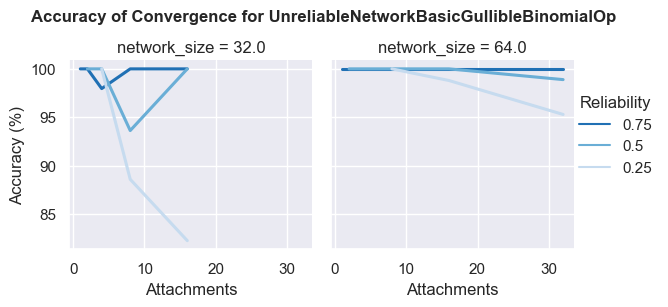

In [73]:
reliability_plot(g_misinfo)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

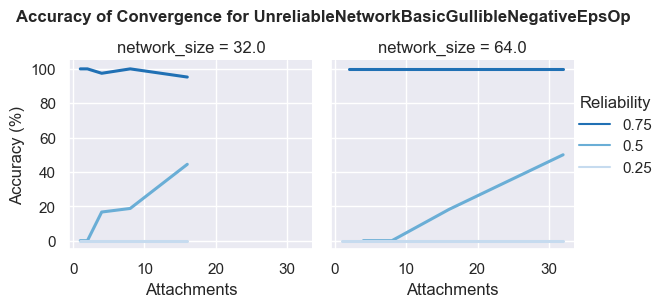

In [74]:
reliability_plot(g_disinfo)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


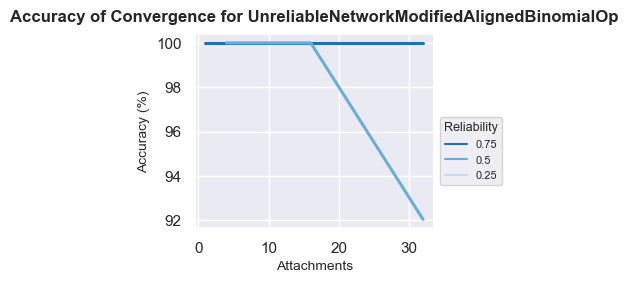

In [75]:
# Set Seaborn style
sns.set()

# Create a smaller figure
plt.figure(figsize=(4,3))  # Adjust size as needed

# Plot the line chart
sns.lineplot(
    data=a_misinfo, 
    x="network_barabasialbert_attachments", 
    y="% of B out of converged",
    hue="reliability",  
    hue_order=sorted(a_disinfo["reliability"].unique(), reverse=True),
    palette=sns.color_palette("Blues", n_colors=len(a_misinfo["reliability"].unique()))[::-1], 
    linewidth=2.2
)

# Labels
plt.xlabel("Attachments", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)

# Move the legend to the upper right corner, outside the plot
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 0.6),
    title="Reliability",
    fontsize=8,
    title_fontsize=9
)

# Set title
op = a_misinfo.op.unique()[0]  # Extract unique operation name
plt.title(f"Accuracy of Convergence for {op}", fontsize=12, y=1.02, weight="bold")

# Adjust layout for better fit
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

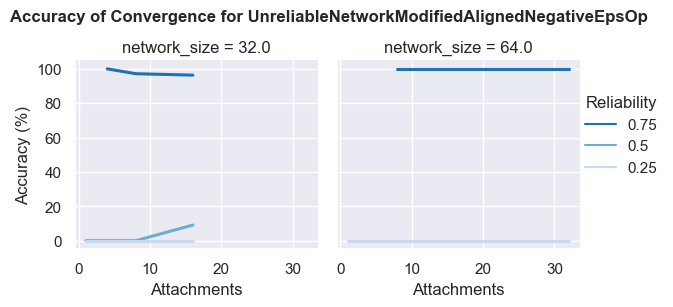

In [76]:
reliability_plot(a_disinfo)

## SIGNIFICANCE TESTING: Chi 2 Test 

In [78]:
pr["proportions_B"] = (pr["B"] / pr["total converged"]) * 100
pr["proportions_not_B"] = (pr["A"] / pr["total converged"]) * 100

In [79]:
filtered_df1 = pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(epsilon == 0.001) and "
    "(trials == 64) and"
    "(op == 'BalaGoyalOp') and"
    "(network_size == 32)"
)

In [80]:
filtered_df2 = pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(epsilon == 0.001) and "
    "(trials == 64) and"
    "(op == 'UnreliableNetworkModifiedAlignedBinomialOp') and"
    "(network_size == 32) and"
    "(reliability == 0.75)"
)

In [81]:
filtered_df = pd.concat([filtered_df1, filtered_df2])

In [82]:
pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(epsilon == 0.001) and "
    "(trials == 64) and"
    "(op == 'UnreliableNetworkModifiedAlignedBinomialOp') and"
    "(reliability == 0.75)"
)

,network_kind,network_size,trials,epsilon,op,reliability,network_barabasialbert_attachments,network_wattsstrogatz_knn,network_wattsstrogatz_probability,network_random_probability,...,?,A,B,not_B,total,total converged,% of B out of total,% of B out of converged,proportions_B,proportions_not_B
139,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,1.0,0.0,0.0,0.0,...,85.0,0,5,85,90,5,5.555556,100.0,100.0,0.0
140,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,2.0,0.0,0.0,0.0,...,25.0,0,65,25,90,65,72.222222,100.0,100.0,0.0
141,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,4.0,0.0,0.0,0.0,...,0.0,0,90,0,90,90,100.000000,100.0,100.0,0.0
142,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,8.0,0.0,0.0,0.0,...,0.0,0,105,0,105,105,100.000000,100.0,100.0,0.0
143,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,16.0,0.0,0.0,0.0,...,0.0,0,100,0,100,100,100.000000,100.0,100.0,0.0
144,barabasialbert,64.0,64.0,0.001,UnreliableNetworkModifiedAlignedBinomialOp,0.75,32.0,0.0,0.0,0.0,...,0.0,0,100,0,100,100,100.000000,100.0,100.0,0.0


## INTER-MODEL COMPARISON

A) RELIABLE VS UNRELIABLE NETWORKS

In [85]:
# Initialize an empty DataFrame for results
chi2_results = pd.DataFrame()

# Get unique operations
operations = filtered_df['op'].unique()

# Loop through the operations
for idx, op in enumerate(operations):
    # Filter data for the current operation
    op_data = filtered_df[filtered_df['op'] == op]

    # Iterate over grouped attributes (excluding 'reliability')
    for (size, epsilon, attachments), group in op_data.groupby(
        ['network_size', 'epsilon', 'network_barabasialbert_attachments']
    ):
        # Access the precomputed proportions directly from the columns
        not_B_op = group['proportions_not_B'].values[0]  # Access first value of the group
        B_op = group['proportions_B'].values[0]  # Access first value of the group

        
        # Compare with other operations
        for compared_op in operations[idx + 1:]:
            # Filtering based on multiple conditions using .loc for clarity
            compared_group = filtered_df.loc[
                (filtered_df['op'] == compared_op) &
                (filtered_df['network_size'] == size) &
                (filtered_df['epsilon'] == epsilon) &
                (filtered_df['network_barabasialbert_attachments'] == attachments)
            ]

            if not compared_group.empty:
                # Access the precomputed proportions for the compared operation
                not_B_compared = compared_group['proportions_not_B'].values[0]  # Access first value of the group
                B_compared = compared_group['proportions_B'].values[0]  # Access first value of the group

                # Perform Chi-squared test
                try:
                    chi2, p, dof, expected = chi2_contingency(
                        [[not_B_op, B_op], [not_B_compared, B_compared]]
                    )
                except ValueError:
                    chi2, p, dof = 0, 1, 0  # Default for invalid data

                # Append results
                chi2_results = pd.concat([
                    chi2_results,
                    pd.DataFrame({
                        'Op': [op],
                        'Size': [size],
                        'Epsilon': [epsilon],
                        'Attachments': [attachments],
                        'Proportions_not_B': [not_B_op],
                        'Proportions_B': [B_op],
                        'Compared_Op': [compared_op],
                        'Compared_Proportions_not_B': [not_B_compared],
                        'Compared_Proportions_B': [B_compared],
                        'Chi2': [chi2],
                        'P_value': [p],
                        'Degrees_of_Freedom': [dof]
                    })
                ], ignore_index=True)



In [86]:
chi2_results

""


In [87]:
file_path = "/Users/fi3502phd/Desktop"
chi2_results.to_csv(f"{file_path}/proportions.csv", index=False)

##### B) UNRELIABLE OPS -- same reliability 

In [89]:
filtered_df = filtered_df = pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(epsilon == 0.001) and "
    "(trials == 64) and"
    "(network_size == 32) and"
    "(reliability == 0.25)"
)

In [90]:
# Initialize an empty DataFrame for results
chi2_results = pd.DataFrame()

# Get unique operations
operations = filtered_df['op'].unique()

# Loop through the operations
for idx, op in enumerate(operations):
    # Filter data for the current operation
    op_data = filtered_df[filtered_df['op'] == op]

    # Iterate over grouped attributes (excluding 'reliability')
    for (kind, size, epsilon, attachments), group in op_data.groupby(
        ['network_kind', 'network_size', 'epsilon', 'network_barabasialbert_attachments']
    ):
        # Access the precomputed proportions directly from the columns
        not_B_op = group['proportions_not_B'].values[0]  # Access first value of the group
        B_op = group['proportions_B'].values[0]  # Access first value of the group

        
        # Compare with other operations
        for compared_op in operations[idx + 1:]:
            # Filtering based on multiple conditions using .loc for clarity
            compared_group = filtered_df.loc[
                (filtered_df['op'] == compared_op) &
                (filtered_df['network_kind'] == kind) &
                (filtered_df['network_size'] == size) &
                (filtered_df['epsilon'] == epsilon) &
                (filtered_df['network_barabasialbert_attachments'] == attachments)
            ]

            if not compared_group.empty:
                # Access the precomputed proportions for the compared operation
                not_B_compared = compared_group['proportions_not_B'].values[0]  # Access first value of the group
                B_compared = compared_group['proportions_B'].values[0]  # Access first value of the group

                # Perform Chi-squared test
                try:
                    chi2, p, dof, expected = chi2_contingency(
                        [[not_B_op, B_op], [not_B_compared, B_compared]]
                    )
                except ValueError:
                    chi2, p, dof = 0, 1, 0  # Default for invalid data

                # Append results
                chi2_results = pd.concat([
                    chi2_results,
                    pd.DataFrame({
                        'Op': [op],
                        'Kind': [kind],
                        'Size': [size],
                        'Epsilon': [epsilon],
                        'Attachments': [attachments],
                        'Proportions_not_B': [not_B_op],
                        'Proportions_B': [B_op],
                        'Compared_Op': [compared_op],
                        'Compared_Proportions_not_B': [not_B_compared],
                        'Compared_Proportions_B': [B_compared],
                        'Chi2': [chi2],
                        'P_value': [p],
                        'Degrees_of_Freedom': [dof]
                    })
                ], ignore_index=True)

In [91]:
chi2_results

,Op,Kind,Size,Epsilon,Attachments,Proportions_not_B,Proportions_B,Compared_Op,Compared_Proportions_not_B,Compared_Proportions_B,Chi2,P_value,Degrees_of_Freedom
0,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,1.0,100.000000,0.000000,UnreliableNetworkBasicGullibleBinomialOp,NaN,NaN,NaN,NaN,1
1,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,1.0,100.000000,0.000000,UnreliableNetworkBasicGullibleNegativeEpsOp,100.000000,0.000000,0.000000,1.000000e+00,0
2,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,1.0,100.000000,0.000000,UnreliableNetworkModifiedAlignedNegativeEpsOp,100.000000,0.000000,0.000000,1.000000e+00,0
3,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,2.0,100.000000,0.000000,UnreliableNetworkBasicGullibleBinomialOp,NaN,NaN,NaN,NaN,1
4,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,2.0,100.000000,0.000000,UnreliableNetworkBasicGullibleNegativeEpsOp,100.000000,0.000000,0.000000,1.000000e+00,0
5,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,2.0,100.000000,0.000000,UnreliableNetworkModifiedAlignedNegativeEpsOp,100.000000,0.000000,0.000000,1.000000e+00,0
6,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,4.0,25.000000,75.000000,UnreliableNetworkBasicGullibleBinomialOp,0.000000,100.000000,26.331429,2.875708e-07,1
7,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,4.0,25.000000,75.000000,UnreliableNetworkBasicGullibleNegativeEpsOp,100.000000,0.000000,116.821333,3.141287e-27,1
8,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,4.0,25.000000,75.000000,UnreliableNetworkModifiedAlignedNegativeEpsOp,100.000000,0.000000,116.821333,3.141287e-27,1
9,UnreliableNetworkBasicAlignedBinomialOp,barabasialbert,32.0,0.001,8.0,11.764706,88.235294,UnreliableNetworkBasicGullibleBinomialOp,11.428571,88.571429,0.000000,1.000000e+00,1


In [92]:
file_path = "/Users/fi3502phd/Desktop"
chi2_results.to_csv(f"{file_path}/proportions.csv", index=False)

## INTRA-MODEL COMPARISONS

A) RELIABILITY

In [95]:
filtered_df = pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(op == 'UnreliableNetworkBasicGullibleNegativeEpsOpG') and"
    "(epsilon == 0.001) and "
    "(trials == 64) and"
    "(network_size == 32)"
)

In [96]:
# Initialize an empty DataFrame for results
chi2_results = pd.DataFrame()

# Get unique reliabilities
reliability = filtered_df['reliability'].unique() 

# Loop through the operations
for idx, rel in enumerate(reliability):
    # Filter data for the current rel
    rel_data = filtered_df[filtered_df['reliability'] == rel]


    # Iterate over grouped attributes
    for (op, kind, size, epsilon, attachments), group in rel_data.groupby(
        ['op', 'network_kind', 'network_size', 'epsilon', 'network_barabasialbert_attachments']
    ):
        # Access the precomputed proportions directly from the columns
        not_B_rel = group['proportions_not_B'].values[0]  # Access first value of the group
        B_rel = group['proportions_B'].values[0]  # Access first value of the group

    
        # Compare with other rels
        for compared_rel in reliability[idx + 1:]:
            # Filtering based on multiple conditions using .loc for clarity
            compared_group = filtered_df.loc[
                (filtered_df['reliability'] == compared_rel) &
                (filtered_df['network_kind'] == kind) &
                (filtered_df['network_size'] == size) &
                (filtered_df['epsilon'] == epsilon) &
                (filtered_df['network_barabasialbert_attachments'] == attachments)
            ]

            not_B_compared = compared_group['proportions_not_B'].values[0]  # Access first value of the group
            B_compared = compared_group['proportions_B'].values[0]  # Access first value of the group

            
            # Perform Chi-squared test
            try:
                chi2, p, dof, expected = chi2_contingency(
                    [[not_B_rel, B_rel], [not_B_compared, B_compared]]
                )
            except ValueError:
                chi2, p, dof = 0, 1, 0  # Default for invalid data

            # Append results
            chi2_results = pd.concat([
                chi2_results,
                pd.DataFrame({
                    'Reliability': [rel],
                    'Op': [op],
                    'Kind': [kind],
                    'Size': [size],
                    'Epsilon': [epsilon],
                    'Attachments': [attachments],
                    'Proportions_not_B': [not_B_rel],
                    'Proportions_B': [B_rel],
                    'Compared_rel': [compared_rel],
                    'Compared_Proportions_not_B': [not_B_compared],
                    'Compared_Proportions_B': [B_compared],
                    'Chi2': [chi2],
                    'P_value': [p],
                    'Degrees_of_Freedom': [dof]
                    })
                ], ignore_index=True)



In [97]:
chi2_results

""


In [98]:
file_path = "/Users/fi3502phd/Desktop"
chi2_results.to_csv(f"{file_path}/proportions.csv", index=False)

B) CONNECTIVITY

In [100]:
filtered_df = pr.query(
    "(network_kind == 'barabasialbert') and " 
    "(op == 'UnreliableNetworkBasicGullibleNegativeEpsOp') and"
    "(epsilon == 0.001) and "
    "(trials == 64) and"
    "(network_size == 32) and"
    "(reliability == 0.25)"
    )

In [101]:
from scipy.stats import chi2_contingency
import numpy as np

# Initialize an empty DataFrame for results
chi2_connectivity = pd.DataFrame()

# Get unique attachments
attachments = filtered_df['network_barabasialbert_attachments'].unique()

# Set hypothetical scaling total for proportions
SCALING_TOTAL = 100

# Loop through attachments
for idx, att in enumerate(attachments):
    # Filter data for the current attachment
    att_data = filtered_df[filtered_df['network_barabasialbert_attachments'] == att]

    # Iterate over grouped attributes
    for (op, kind, size, epsilon, reliability), group in att_data.groupby(
        ['op', 'network_kind', 'network_size', 'epsilon', 'reliability']
    ):

        not_B_att = group['proportions_not_B'].values[0]  # Access first value of the group
        B_att = group['proportions_B'].values[0]  # Access first value of the group

        # Compare with other attachments (including itself)
        for compared_att in attachments:
            # Filter comparison group
            compared_group = filtered_df.loc[
                (filtered_df['network_barabasialbert_attachments'] == compared_att) &
                (filtered_df['network_kind'] == kind) &
                (filtered_df['network_size'] == size) &
                (filtered_df['epsilon'] == epsilon) &
                (filtered_df['reliability'] == reliability)
            ]
            
            not_B_compared = compared_group['proportions_not_B'].values[0]  # Access first value of the group
            B_compared = compared_group['proportions_B'].values[0]  # Access first value of the group

            # Create a contingency table using scaled proportions
            contingency_table = [
                [not_B_att, B_att],
                [not_B_compared, B_compared]
            ]
            
            # Check if the table has any row or column with zero sum, i.e., a degenerate case
            if np.any(np.sum(contingency_table, axis=0) == 0) or np.any(np.sum(contingency_table, axis=1) == 0):
                chi2, p, dof = 0, 1, 0  # Set p-value to 1 for no difference
            else:
                try:
                    chi2, p, dof, expected = chi2_contingency(contingency_table)
                except ValueError:
                    chi2, p, dof = np.nan, np.nan, 0  # In case of a calculation issue

            # Append results to DataFrame
            chi2_connectivity = pd.concat([
                chi2_connectivity,
                pd.DataFrame({
                    'Attachments': [att],
                    'Op': [op],
                    'Kind': [kind],
                    'Size': [size],
                    'Epsilon': [epsilon],
                    'Reliability': [reliability],
                    'Proportions_not_B': [not_B_att],
                    'Proportions_B': [B_att],
                    'Compared_attachments': [compared_att],
                    'Compared_Proportions_not_B': [not_B_compared],
                    'Compared_Proportions_B': [B_compared],
                    'Chi2': [chi2],
                    'P_value': [p],
                    'Degrees_of_Freedom': [dof]
                })
            ], ignore_index=True)

# Save the results
chi2_connectivity.to_csv('chi2_connectivity_results_corrected.csv', index=False)

In [102]:
chi2_connectivity

,Attachments,Op,Kind,Size,Epsilon,Reliability,Proportions_not_B,Proportions_B,Compared_attachments,Compared_Proportions_not_B,Compared_Proportions_B,Chi2,P_value,Degrees_of_Freedom
0,1.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,1.0,100.0,0.0,0,1,0
1,1.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,2.0,100.0,0.0,0,1,0
2,1.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,4.0,100.0,0.0,0,1,0
3,1.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,8.0,100.0,0.0,0,1,0
4,1.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,16.0,100.0,0.0,0,1,0
5,2.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,1.0,100.0,0.0,0,1,0
6,2.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,2.0,100.0,0.0,0,1,0
7,2.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,4.0,100.0,0.0,0,1,0
8,2.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,8.0,100.0,0.0,0,1,0
9,2.0,UnreliableNetworkBasicGullibleNegativeEpsOp,barabasialbert,32.0,0.001,0.25,100.0,0.0,16.0,100.0,0.0,0,1,0


In [103]:
file_path = "/Users/fi3502phd/Desktop"
chi2_connectivity.to_csv(f"{file_path}/proportions.csv", index=False)

##### 